# Employee Retention

In this challenge, you have a data set with info about the employees and have to predict when
employees are going to quit by understanding the main drivers of employee churn.

We got employee data from a few companies. We have data about all employees who joined
from 2011/01/24 to 2015/12/13. For each employee, we also know if they are still at the
company as of 2015/12/13 or they have quit. Beside that, we have general info about the
employee, such as avg salary during her tenure, dept, and yrs of experience.
As said above, the goal is to predict employee retention and understand its main drivers.
Specifically, you should:
* Assume, for each company, that the headcount starts from zero on 2011/01/23. Estimate
employee headcount, for each company, on each day, from 2011/01/24 to 2015/12/13.
That is, if by 2012/03/02 2000 people have joined company 1 and 1000 of them have
already quit, then company headcount on 2012/03/02 for company 1 would be 1000.
You should create a table with 3 columns: day, employee_headcount, company_id.
* What are the main factors that drive employee churn? Do they make sense? Explain your
findings.
* If you could add to this data set just one variable that could help explain employee churn,
what would that be?

In [1]:
# Import necessary libraries

import warnings
warnings.simplefilter('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn import preprocessing
from sklearn import tree
# import graphviz
from sklearn.tree import DecisionTreeClassifier

## 1. Data overview

In [2]:
# Import data set

df = pd.read_csv('Employee_Rentation.csv')
df.head()

,Unnamed: 0,employee_id,company_id,dept,seniority,salary,join_date,quit_date
0,1,13021.0,7,customer_service,28,89000.0,2014-03-24,2015-10-30
1,2,825355.0,7,marketing,20,183000.0,2013-04-29,2014-04-04
2,3,927315.0,4,marketing,14,101000.0,2014-10-13,NaN
3,4,662910.0,7,customer_service,20,115000.0,2012-05-14,2013-06-07
4,5,256971.0,2,data_science,23,276000.0,2011-10-17,2014-08-22


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24702 entries, 0 to 24701
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Unnamed: 0   24702 non-null  int64  
 1   employee_id  24702 non-null  float64
 2   company_id   24702 non-null  int64  
 3   dept         24702 non-null  object 
 4   seniority    24702 non-null  int64  
 5   salary       24702 non-null  float64
 6   join_date    24702 non-null  object 
 7   quit_date    13510 non-null  object 
dtypes: float64(2), int64(3), object(3)
memory usage: 1.5+ MB


Some 'quit_date' data are missing.

In [4]:
df.describe()

,Unnamed: 0,employee_id,company_id,seniority,salary
count,24702.000000,24702.000000,24702.000000,24702.000000,24702.000000
mean,12351.500000,501604.403530,3.426969,14.127803,138183.345478
std,7130.997511,288909.026101,2.700011,8.089520,76058.184573
min,1.000000,36.000000,1.000000,1.000000,17000.000000
25%,6176.250000,250133.750000,1.000000,7.000000,79000.000000
50%,12351.500000,500793.000000,2.000000,14.000000,123000.000000
75%,18526.750000,753137.250000,5.000000,21.000000,187000.000000
max,24702.000000,999969.000000,12.000000,99.000000,408000.000000


## 2. Create employee headcount table

In [5]:
# Required date range and unique company id

date_range = pd.date_range(start='1/24/2011', end='12/13/2015')
company_id = np.sort(df['company_id'].unique())

In [6]:
# Day, company, and corresponding headcount

day = []
company = []
headcount = []

for i in range(len(date_range)):
    date = date_range[i].strftime('%Y-%m-%d')
    for ind in company_id:
        df_company = df[df['company_id'] == ind]
        headcount_join = len(df_company[df_company['join_date']<=date]) 
        headcount_quit = len(df_company.dropna()[df_company['quit_date']<=date])
        day.append(date)
        company.append(ind)
        headcount.append(headcount_join - headcount_quit)

In [7]:
# Create table

table = pd.DataFrame({'day': day, 'company_id': company, 'employee_headcount': headcount}, 
                     columns=['day', 'company_id', 'employee_headcount'])

table.head()

,day,company_id,employee_headcount
0,2011-01-24,1,25
1,2011-01-24,2,17
2,2011-01-24,3,9
3,2011-01-24,4,12
4,2011-01-24,5,5


## 3. Churn analysis

Now we want to understand the employee retention. First we need to do some feature engineering. That is, extract variables from the quitting_date column.

In [8]:
# The total days of being employed should matter, so here we calculate this

df2 = df.dropna()
df2[['join_date','quit_date']] = df2[['join_date','quit_date']].apply(pd.to_datetime)
df2['length'] = (df2['quit_date'] - df2['join_date']).dt.days

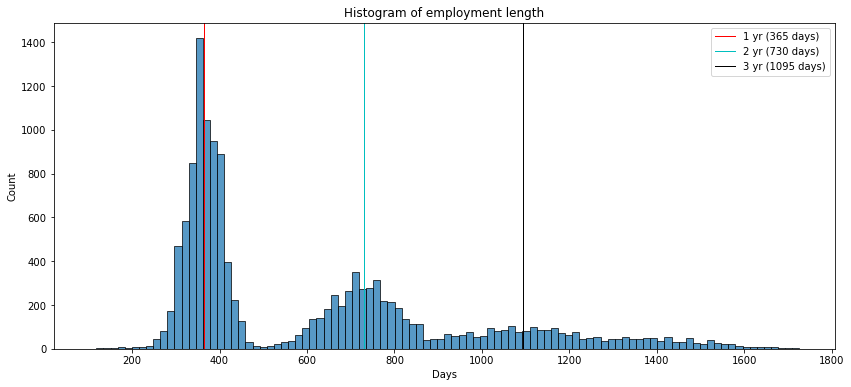

In [14]:
# Visualize the employment length

fig, ax = plt.subplots(figsize = (14, 6))
sns.histplot(df2['length'], bins=100, ax=ax)
plt.axvline(x=365,linewidth=1, color='r', label='1 yr (365 days)')
plt.axvline(x=730, linewidth=1, color='c', label='2 yr (730 days)')
plt.axvline(x=1095, linewidth=1, color='k', label='3 yr (1095 days)')
plt.legend()
ax.set_title('Histogram of employment length')
ax.set_xlabel('Days')
plt.show()

This is quite interesting as there are peaks around each employee year anniversaries.

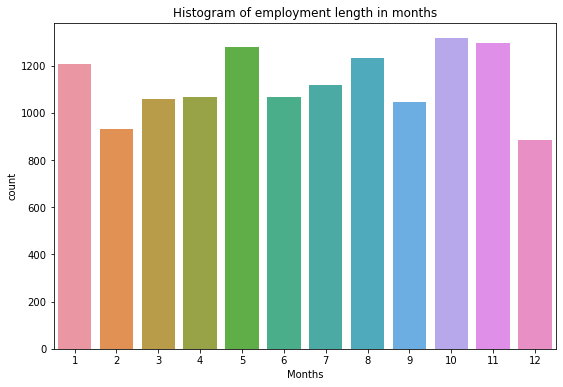

In [16]:
# Visualize by month

fig, ax = plt.subplots(figsize = (9, 6))
sns.countplot(df2['quit_date'].dt.month, ax=ax)
ax.set_title('Histogram of employment length in months')
ax.set_xlabel('Months')
plt.show()

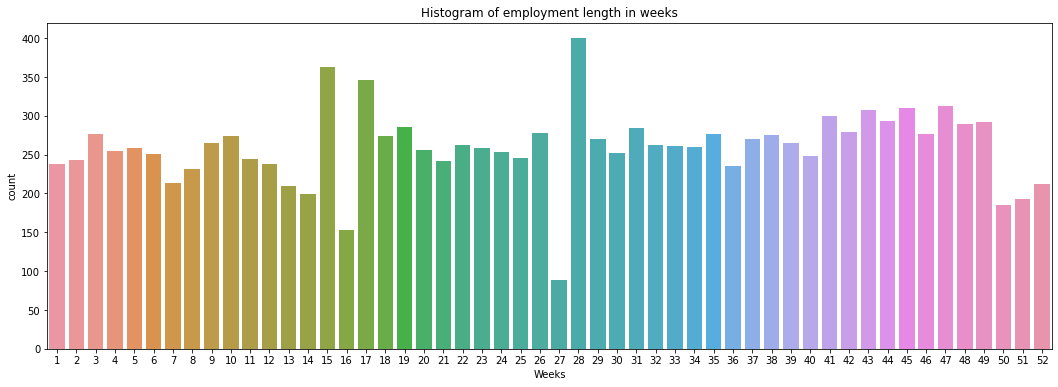

In [18]:
# Visualize by weeks

fig, ax = plt.subplots(figsize = (18, 6))
sns.countplot(df2['quit_date'].dt.week, ax=ax)
ax.set_title('Histogram of employment length in weeks')
# ax = df2['quit_date'].dt.week.value_counts().sort_index().plot.bar()
ax.set_xlabel('Weeks')
plt.show()

Now, let’s see if we find the characteristics of the people who quit early. Looking at the histogram of
employment_length, it looks like we could define early quitters as those people who quit within 1 yr or so.
So, let’s create two classes of users : quit within 13 months or not (if they haven’t been in the current
company for at least 13 months, we remove them).

In [19]:
# Create binary class

stop_date = pd.to_datetime('2015-12-13') - pd.DateOffset(days=365 + 31)
df[['join_date','quit_date']] = df[['join_date','quit_date']].apply(pd.to_datetime)
df_recentYear = df[df['join_date'] < stop_date]

quit = df_recentYear['quit_date'].isnull() | (df_recentYear['quit_date'] > (df_recentYear['join_date'] + pd.DateOffset(days=396)))
df_recentYear['quit'] = 1 - quit.astype(int)

df_recentYear.head()

,Unnamed: 0,employee_id,company_id,dept,seniority,salary,join_date,quit_date,quit
0,1,13021.0,7,customer_service,28,89000.0,2014-03-24,2015-10-30,0
1,2,825355.0,7,marketing,20,183000.0,2013-04-29,2014-04-04,1
2,3,927315.0,4,marketing,14,101000.0,2014-10-13,NaT,0
3,4,662910.0,7,customer_service,20,115000.0,2012-05-14,2013-06-07,1
4,5,256971.0,2,data_science,23,276000.0,2011-10-17,2014-08-22,0


Let’s now build a model. Here we can just care about: seniority, salary, dept and company. A simple decision tree is probably more than enough.

In [20]:
# Data processing

le = preprocessing.LabelEncoder()

train_x = df_recentYear[['company_id', 'seniority', 'salary']]
train_x['dept'] = le.fit_transform(df_recentYear['dept'])

train_y = df_recentYear['quit'].values
train_x.shape

(19270, 4)

In [21]:
# Build decision tree

clf = DecisionTreeClassifier(max_depth=3, min_samples_leaf=30, random_state=42)
clf = clf.fit(X=train_x, y=train_y)

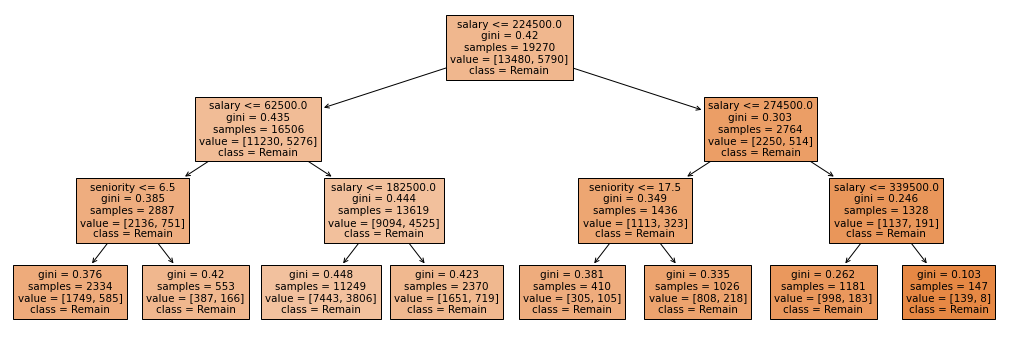

In [22]:
# Visualization 

features = list(train_x.columns)
targets = ['Remain', 'Quit']

fig, ax = plt.subplots(figsize=(18, 6))
tree.plot_tree(clf, feature_names = features, class_names = targets, filled = True, ax=ax)
# or import graphviz
#    graphviz.Source(tree.export_graphviz(clf, out_file=None, feature_names=features, class_names=targets, 
#                              filled=True, rounded=True, special_characters=True))  

plt.show()

In [23]:
# Feature importance

importance = sorted(zip(features, clf.feature_importances_), key=lambda x:x[1], reverse=True)
for feature, val in importance:
    print('{0:10s} | {1:.5f}'.format(feature, val))

salary     | 0.97439
seniority  | 0.02561
company_id | 0.00000
dept       | 0.00000


We noticed that salary matters the most. Moreover, it is interesting though that, looking at the terminal nodes, the way the tree split is: If salary between 62500
and 224500, the employee has higher probability of being an early quitter which
means that people who make a lot of money and very little are not likely to quit.

By plotting the proportion of early quitter by salary percentile, this becomes quite clear:

In [27]:
# Calculate the salary percentiles and proportion of early quitter.

df_recentYear['salary_percentile']=pd.qcut(df_recentYear['salary'], 50, labels=np.arange(1, 51))

proportion_early_quitters = [0 for _ in range(50)]

for ind in range(1, 51):
    proportion_early_quitters[ind - 1] = df_recentYear[df_recentYear['salary_percentile'] == ind]['quit'].mean()

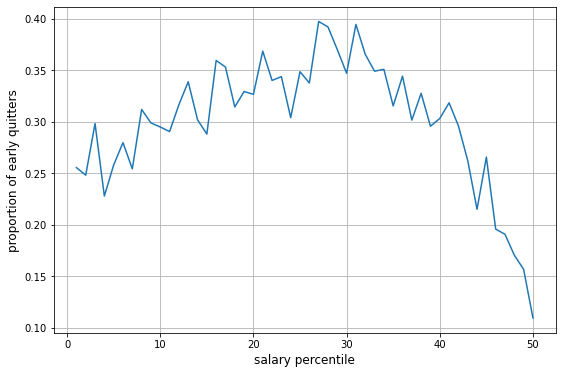

In [35]:
# Visualize the proportion of early quitter by salary percentile

fig, ax = plt.subplots(figsize = (9, 6))
ax = plt.plot(np.arange(1, 51), proportion_early_quitters)
plt.xlabel('salary percentile', fontsize=12)
plt.ylabel('proportion of early quitters', fontsize=12)
plt.grid(True)
plt.show()

## 4. Conclusions

1. Given how important is salary, I would definitely love to have as a variable the salary the employee
who quit was offered in the next job. Otherwise, things like: promotions or raises received during
the employee tenure would be interesting.
2. The major findings are that employees quit at year anniversaries or at the beginning of the year.
Both cases make sense. Even if you don’t like your current job, you often stay for 1 yr before
quitting + you often get stocks after 1 yr so it makes sense to wait. Also, the beginning of the year is
well known to be the best time to change job: companies are hiring more and you often want to stay
until end of Dec to get the calendar year bonus.
3. Employees with low and high salaries are less likely to quit. Probably because employees with high
salaries are happy there and employees with low salaries are not that marketable, so they have a
hard time finding a new job.